In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime

In [4]:
df = pd.read_csv('test_orders.csv')
df['beg_month'] = pd.to_datetime(df['beg_month'])

In [8]:
# flake8: noqa: E501

import numpy as np
from numpy.core.fromnumeric import mean
import pandas as pd
from pandas.core.indexes.api import get_objs_combined_axis
import pmdarima
from datetime import datetime
import typing
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error # upgrade to the the latest scikit-learn pip install -U scikit-learn
import random

## Changes to be made
## 1 would like to add an argument 

class TSFM(object):
    def __init__(self,
                 df: pd.core.frame.DataFrame,
                 n_pred_period: int,
                 date_variable: typing.Union[int, str],
                 value_variable: typing.Union[int, str],
                 target_variable: str,
                 stop_date: str,         # stop date of train set, to split df to train and test sets
                 section_list: list = None,
                 cycle_length: int = 12,
                 alpha: float = 0.05,
                 stepwise: bool = True,
                 start_order: tuple = (0, None, 0),
                 max_order: tuple = (4, 2, 5),
                 start_seasonal_order: tuple = (0, 0, 0),
                 max_seasonal_order: tuple = (2, 2, 4)):
        self.target_variable = target_variable
        # self.n_pred_period = n_pred_period + abs((datetime.strptime(df[date_variable].to_numpy()[-1])  - datetime.strptime(stop_date, "%Y-%m-%d")).days)
        self.n_pred_period = n_pred_period
        self.stop_date = stop_date
        self.cycle_length = cycle_length
        self.alpha = alpha
        self.stepwise = stepwise
        self.start_order = start_order
        self.max_order = max_order
        self.start_seasonal_order = start_seasonal_order
        self.max_seasonal_order = max_seasonal_order

        (start_p, start_d, start_q) = start_order
        (max_p, max_d, max_q) = max_order
        (start_P, start_D, start_Q) = start_seasonal_order
        (max_P, max_D, max_Q) = max_seasonal_order

        # train and test df must have date as index, and 2 columns: sections(e.g. territory) and values(e.g. order_volume)
        if type(date_variable) is int:
            date_variable = df.columns[date_variable]
        if type(value_variable) is int:
            value_variable = df.columns[value_variable]
        # Select relevant columns for train and test df, create empty pred df
        self.columns = [date_variable, target_variable, value_variable]
        df[self.columns[0]] = pd.to_datetime(df[self.columns[0]])
        

        self.df = df.copy()

        # keys: sections(territories), value: list(train, test, pred), for easy storing and fetching data
        self.df_dict = dict()
        self.model_dict = dict()
        self.adjusted_model_dict = dict()

        # Iterate through the unique sections
        self.section_list = section_list
        if self.section_list is None:
            self.section_list = df[target_variable].unique()
        for section in self.section_list:
            print("Inspecting", section, "...")
            temp_actual_df = self.get_actual_data(section=section, is_adjusted=False)
            if temp_actual_df.shape[0] >= 2 * cycle_length:
                # train actual data
                print("Training", temp_actual_df.shape[0], "actual records ...")
                arima_model = pmdarima.auto_arima(temp_actual_df[temp_actual_df.columns[-1]],
                                                start_p=start_p, start_P=start_P,
                                                start_q=start_q, start_Q=start_Q,
                                                d=start_d, D=start_D,
                                                max_p=max_p, max_P=max_P,
                                                max_d=max_d, max_D=max_D,
                                                max_q=max_q, max_Q=max_Q,
                                                trace=True, m=cycle_length, stepwise=stepwise)
                self.model_dict[section] = arima_model

                temp_adjusted_actual_df = self.get_actual_data(section=section, is_adjusted=True)
                # train adjusted actual data
                print("Training", temp_adjusted_actual_df.shape[0], "adjusted actual records ...")
                arima_model = pmdarima.auto_arima(temp_adjusted_actual_df[temp_adjusted_actual_df.columns[-1]],
                                                start_p=start_p, start_P=start_P,
                                                start_q=start_q, start_Q=start_Q,
                                                d=start_d, D=start_D,
                                                max_p=max_p, max_P=max_P,
                                                max_d=max_d, max_D=max_D,
                                                max_q=max_q, max_Q=max_Q,
                                                trace=True, m=cycle_length, stepwise=stepwise)
                self.adjusted_model_dict[section] = arima_model
            else:
                print("Number of data points in Section", section, "is too small (" + str(
                    temp_actual_df.shape[0]) + ". Must be at least twice the declared cycle length.")

    # DF Getters--------------------------------------------------------------
    def get_actual_data(self, section: str, is_adjusted: bool = True,):
        agg_df = self.df[self.columns].groupby(self.columns[0:2], as_index=False).sum().copy()
        agg_df = agg_df.query(self.columns[1] + "==" + "'" + section + "'")[[self.columns[0], self.columns[2]]]
        agg_df.set_index(self.columns[0], inplace=True)
        agg_df = TSFM.to_monthly(agg_df)
        if is_adjusted:
            return self.anomaly_filter(agg_df, alpha = self.alpha)
        return agg_df.copy()

    def get_train_data(self, section: str,):  ## added stop date
        actual_df = self.get_actual_data(section)
        return actual_df.iloc[lambda x: x.index <= self.stop_date].copy()

    def get_test_data(self, section: str,):
        actual_df = self.get_actual_data(section)
        return actual_df.iloc[lambda x: x.index > self.stop_date].copy()

    def get_pred_data(self, section: str, return_conf_int: bool = False, is_adjusted: bool = True):
        actual_df = self.get_actual_data(section, is_adjusted)
        model = self.get_model(section=section, is_adjusted=is_adjusted)
        print(model.predict(self.n_pred_period, return_conf_int=return_conf_int))
        pred, conf_int = model.predict(self.n_pred_period, return_conf_int=True)

        temp_pred_df = pd.DataFrame(
            data={
                self.columns[0]: pd.date_range(max(actual_df.index),freq='MS',periods=self.n_pred_period+1)[1:],
                self.columns[1]: [section for x in range(len(pred))],
                self.columns[-1]: pred})  # Use numbers inplace of future dates for now)
        temp_pred_df = temp_pred_df[[self.columns[0], self.columns[2]]]
        temp_pred_df.set_index(self.columns[0], inplace=True)
        if return_conf_int:
            return temp_pred_df.copy(), conf_int
        return temp_pred_df.copy()

    def get_pred_df(self):
        return_df = pd.DataFrame(columns=self.columns)
        for section in self.section_list:
            actual_pred = self.get_pred_data(section, is_adjusted=False)
            adjusted_actual_pred = self.get_pred_data(section, is_adjusted=True)
            pred = pd.DataFrame(data={actual_pred.columns[0]: actual_pred.iloc[:, 0].to_numpy(), "value2": adjusted_actual_pred.iloc[:, 0].to_numpy()})
            pred.reset_index(inplace=True)
            pred[self.target_variable] = [section for x in range(pred.shape[0])]
            return_df = return_df.append(pred, ignore_index=True)
        return_df.sort_values(by=[self.columns[1], self.columns[0]], inplace=True, ignore_index=True)
        return return_df

    # Model Getters----------------------------------------------------------
    def get_model(self, section: str, is_adjusted: bool = True):
        if is_adjusted:
            return self.adjusted_model_dict[section]
        return self.model_dict[section]
    
    # Plot Function-----------------------------------------------------------
    def plot(self, section: str):
        actual = self.get_actual_data(section, is_adjusted=False)
        adjusted_actual, conf_int_df = self.anomaly_filter(actual, return_conf_int=True, alpha = self.alpha)
        # pred, ci = self.get_pred_data(section, return_conf_int=True)

        actual_pred = self.get_pred_data(section, is_adjusted=False)
        adjusted_actual_pred = self.get_pred_data(section, is_adjusted=True)

        fig, ax = plt.subplots(figsize=(14,6))
        ax.plot(actual.index, actual[actual.columns[0]].to_numpy(),label="Actual")   #Actuals This should come from original DS (all actuals)
        ax.plot(adjusted_actual.index, adjusted_actual[adjusted_actual.columns[0]].to_numpy(),'-g', label="Adjusted Actual")   
        # ax.plot(pred.index, pred[pred.columns[0]], '-r',alpha=0.75,label="Forecast")  ## Pred
        ax.fill_between(conf_int_df.index, conf_int_df.iloc[:, 0], conf_int_df.iloc[:, 1],alpha=0.3, color='b')  ## Conf intervals
        
        ax.plot(actual_pred.index, actual_pred.iloc[:, 0], '--b',alpha=0.75,label="Actual Forecast")
        ax.plot(adjusted_actual_pred.index, adjusted_actual_pred.iloc[:, 0], '--g',alpha=0.75,label="Adjusted Actual Forecast")
        plt.title('Forecast Model')
        plt.xlabel('Year')
        plt.ylabel('Forecast Accurary')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())

        plt.legend()
        plt.show()

    def anomaly_filter(self,
                       df: pd.core.frame.DataFrame,
                       return_conf_int: bool = False, 
                       n_rolling_period: int = 12,
                       alpha: float = 0.05):
        df = df.copy()
        train = df.iloc[lambda x: x.index <= self.stop_date]
        stop_date = max(train.index)
        returning_ic_list = list()
        (start_p, start_d, start_q) = self.start_order
        (max_p, max_d, max_q) = self.max_order
        (start_P, start_D, start_Q) = self.start_seasonal_order
        (max_P, max_D, max_Q) = self.max_seasonal_order
        for i in range(train.shape[0], df.shape[0], n_rolling_period):
            arima_model = pmdarima.auto_arima(train[train.columns[0]],
                                                start_p=start_p, start_P=start_P,
                                                start_q=start_q, start_Q=start_Q,
                                                d=start_d, D=start_D,
                                                max_p=max_p, max_P=max_P,
                                                max_d=max_d, max_D=max_D,
                                                max_q=max_q, max_Q=max_Q,
                                                trace=True, m=self.cycle_length, stepwise=self.stepwise)
            temp_actual_df = df.iloc[i:min(i+n_rolling_period, df.shape[0]), :]
            temp_pred, ic_list = arima_model.predict(n_rolling_period, return_conf_int=True, alpha=alpha)
            for j in range(temp_actual_df.shape[0]):
                temp_actual = temp_actual_df.iloc[j, 0]
                ic = ic_list[j]
                if temp_actual < ic[0] or temp_actual > ic[1]:
                    temp_actual_df.iloc[j, 0] = temp_pred[j]
            train = train.append(temp_actual_df)
            returning_ic_list = returning_ic_list + ic_list.tolist()
        train[train.columns[0]] = train[train.columns[0]].astype('float')
        train = train.asfreq('MS')
        if return_conf_int:
            returning_ic_list = np.array(returning_ic_list)
            ic_df = pd.DataFrame(
                data={
                    'lower': returning_ic_list[:, 0],
                    'upper': returning_ic_list[:, 1],
                },
                index=pd.date_range(stop_date,freq='MS',periods=returning_ic_list.shape[0]+1)[1:]
            )
            return train.copy(), ic_df
        return train.copy()
    
    def cross_validate(self,section: str, is_adjusted: bool):
        actual_df = self.get_actual_data(section, is_adjusted)
        actual_arr = actual_df[actual_df.columns[0]].to_numpy(dtype='float')
        trained_model = self.get_model(section, is_adjusted)
        order = trained_model.order
        seasonal_order = trained_model.seasonal_order

        model = pmdarima.ARIMA(order = order, seasonal_order=seasonal_order)
        MAE = list()
        MAPE = list()
        tscv = TimeSeriesSplit(10)
        for train_index, test_index in tscv.split(X=actual_df.index):
            if len(train_index) >= 24:
                print("train_index = {}".format(train_index))
                print("test_index = {}".format(test_index))
                train = actual_arr[train_index]
                test = actual_arr[test_index]
                print("train = {}".format(train))
                print("test = {}".format(test))
                model.fit(train)
                pred = model.predict(len(test))
                mae = mean_absolute_error(test, pred)
                mape = mean_absolute_percentage_error(test, pred)
                MAE.append(mae)
                MAPE.append(mape)
                
                print("MAE = {}".format(mae))
                print("MAPE = {}".format(mape))
                print("-"*50)
            else:
                pass
        print("MAE = {}".format(MAE))
        print("MAPE = {}".format(MAPE))
        print("Average MAE = {}".format(np.mean(MAE)))
        print("Average MAPE = {}".format(np.mean(MAPE)))
    
    def test_anomaly_filter(self, section):
        actual = self.get_actual_data(section, is_adjusted=False)
        max_val = max(actual.iloc[:, 0])*1.5
        min_val = min(actual.iloc[:, 0])*0.5
        print(actual)

        train = self.get_train_data(section=section)
        test = self.get_test_data(section)
        test = test.apply(lambda x: random.randint(int(min_val), int(max_val)), axis=1, result_type='broadcast')
        actual = train.append(test).copy().astype('int')
        print(actual)

        adjusted_actual, conf_int_df = self.anomaly_filter(actual, return_conf_int=True)
        # pred, ci = self.get_pred_data(section, return_conf_int=True)

        actual_pred = self.get_pred_data(section, is_adjusted=False)
        adjusted_actual_pred = self.get_pred_data(section, is_adjusted=True)

        fig, ax = plt.subplots(1, figsize=(14,6))
        ax.plot(actual.index, actual[actual.columns[0]].to_numpy(),label="Actual")   #Actuals This should come from original DS (all actuals)
        ax.plot(adjusted_actual.index, adjusted_actual[adjusted_actual.columns[0]].to_numpy(),'-g', label="Adjusted Actual")   
        # ax.plot(pred.index, pred[pred.columns[0]], '-r',alpha=0.75,label="Forecast")  ## Pred
        ax.fill_between(conf_int_df.index, conf_int_df.iloc[:, 0], conf_int_df.iloc[:, 1],alpha=0.3, color='b')  ## Conf intervals
        
        ax.plot(actual_pred.index, actual_pred.iloc[:, 0], '--b',alpha=0.75,label="Actual Forecast")
        ax.plot(adjusted_actual_pred.index, adjusted_actual_pred.iloc[:, 0], '--g',alpha=0.75,label="Adjusted Actual Forecast")
        plt.title('Forecast Model')
        plt.xlabel('Year')
        plt.ylabel('Forecast Accurary')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())

        plt.legend()
        plt.show()

    @classmethod
    def to_monthly(cls, df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
        return df.resample('MS').sum()


# Stepwise

## alpha = .05

In [9]:
sw_tsfm_05 = TSFM(df=df, n_pred_period=24, date_variable='beg_month', target_variable='prod', value_variable='test', stop_date="2019-12-01", section_list=["HOME", "ACUTE"], stepwise=True, alpha=.01)

Inspecting HOME ...
Training 48 actual records ...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2376.722, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2373.520, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2373.240, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2374.824, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2374.390, Time=0.09 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2374.950, Time=0.63 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=2374.361, Time=0.54 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2373.007, Time=0.18 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=2374.604, Time=0.37 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=1.68 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2374.762, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=2373.408, Time=0.19 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=2369.174, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : A

In [10]:
sw_tsfm_05.get_pred_df()

[2.94856077e+11 2.93422451e+11 2.94484827e+11 2.93627200e+11
 2.93408787e+11 2.92805652e+11 2.92424232e+11 2.92829351e+11
 2.93378944e+11 2.93100812e+11 2.93779389e+11 2.93209273e+11
 2.93370204e+11 2.93223118e+11 2.93332115e+11 2.93244125e+11
 2.93221716e+11 2.93159836e+11 2.93120704e+11 2.93162268e+11
 2.93218654e+11 2.93190119e+11 2.93259739e+11 2.93201247e+11]
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1780.495, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1778.874, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1779.158, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1778.662, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1779.313, Time=0.09 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1779.657, Time=0.08 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1781.112, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1779.448, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1779.498, T

,beg_month,prod,test,index,value2
0,NaN,ACUTE,1.309184e+11,0.0,1.309184e+11
1,NaN,ACUTE,1.336582e+11,1.0,1.336582e+11
2,NaN,ACUTE,1.354770e+11,2.0,1.354770e+11
3,NaN,ACUTE,1.290846e+11,3.0,1.290846e+11
4,NaN,ACUTE,1.330289e+11,4.0,1.330289e+11
5,NaN,ACUTE,1.385339e+11,5.0,1.385339e+11
6,NaN,ACUTE,1.333145e+11,6.0,1.333145e+11
7,NaN,ACUTE,1.315423e+11,7.0,1.315423e+11
8,NaN,ACUTE,1.367995e+11,8.0,1.367995e+11
9,NaN,ACUTE,1.278393e+11,9.0,1.278393e+11


In [16]:
temp = sw_tsfm_05.get_pred_data("ACUTE", is_adjusted=False)

[1.30918354e+11 1.33658238e+11 1.35477020e+11 1.29084596e+11
 1.33028924e+11 1.38533949e+11 1.33314466e+11 1.31542327e+11
 1.36799483e+11 1.27839255e+11 1.37056543e+11 1.25554777e+11
 1.34588098e+11 1.34588098e+11 1.34588098e+11 1.34588098e+11
 1.34588098e+11 1.34588098e+11 1.34588098e+11 1.34588098e+11
 1.34588098e+11 1.34588098e+11 1.34588098e+11 1.34588098e+11]


In [18]:
temp[temp.columns[0]].to_numpy()

array([1.30918354e+11, 1.33658238e+11, 1.35477020e+11, 1.29084596e+11,
       1.33028924e+11, 1.38533949e+11, 1.33314466e+11, 1.31542327e+11,
       1.36799483e+11, 1.27839255e+11, 1.37056543e+11, 1.25554777e+11,
       1.34588098e+11, 1.34588098e+11, 1.34588098e+11, 1.34588098e+11,
       1.34588098e+11, 1.34588098e+11, 1.34588098e+11, 1.34588098e+11,
       1.34588098e+11, 1.34588098e+11, 1.34588098e+11, 1.34588098e+11])

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1109.793, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1113.091, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1113.312, Time=0.11 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1109.290, Time=0.04 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1109.171, Time=0.13 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=1111.088, Time=0.20 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1112.015, Time=0.23 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1112.166, Time=0.36 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=0.92 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=1111.121, Time=0.18 sec

Best model:  ARIMA(0,1,0)(2,1,0)[12]          
Total fit time: 2.747 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1416.031, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC

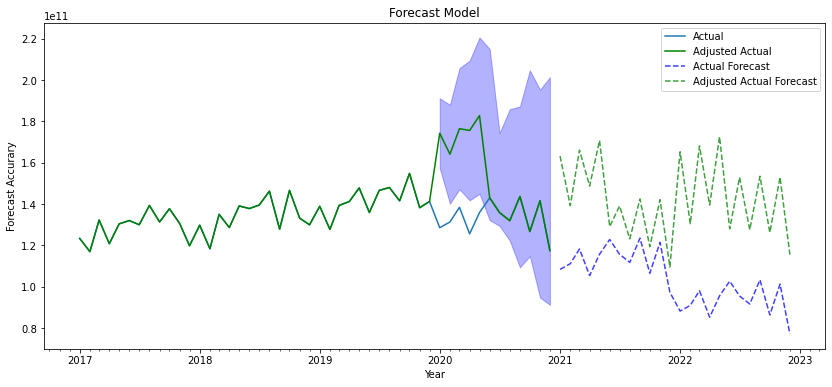

In [24]:
sw_tsfm.plot("ACUTE")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1150.214, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1151.888, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1151.169, Time=0.08 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1151.388, Time=0.05 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1149.190, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1150.566, Time=0.22 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=1152.567, Time=0.21 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1151.870, Time=0.15 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1153.218, Time=0.20 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1151.179, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 1.410 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1449.921, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             

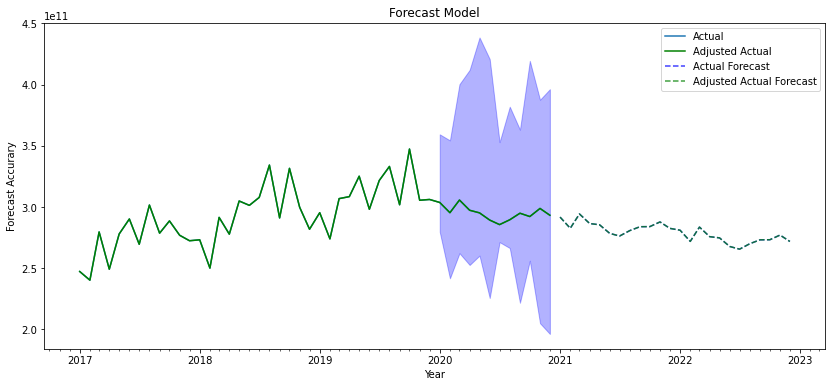

In [25]:
sw_tsfm.plot("HOME")

In [75]:
sw_tsfm.get_model("ACUTE", True)

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 1, 2, 12),
      suppress_warnings=True, with_intercept=False)

In [76]:
sw_tsfm.get_model("ACUTE", False)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

## alpha = 0.01

In [8]:
sw_tsfm_01 = TSFM(df=df, n_pred_period=24, date_variable='beg_month', target_variable='prod', value_variable='test', stop_date="2019-12-01", section_list=["HOME", "ACUTE"], stepwise=True, alpha=.01)

Inspecting HOME ...
Training 48 actual records ...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1764.684, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1768.641, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1766.294, Time=0.20 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1764.637, Time=0.11 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1772.957, Time=0.31 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1764.266, Time=0.10 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1764.780, Time=0.55 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.01 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1768.556, Time=0.26 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1770.228, Time=0.46 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1766.080, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 3.841 seconds
Performing stepwise search to mini

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1109.793, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1113.091, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1113.312, Time=0.13 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1109.290, Time=0.05 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1109.171, Time=0.15 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=1111.088, Time=0.22 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1112.015, Time=0.24 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1112.166, Time=0.41 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=0.98 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=1111.121, Time=0.20 sec

Best model:  ARIMA(0,1,0)(2,1,0)[12]          
Total fit time: 3.053 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1416.031, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC

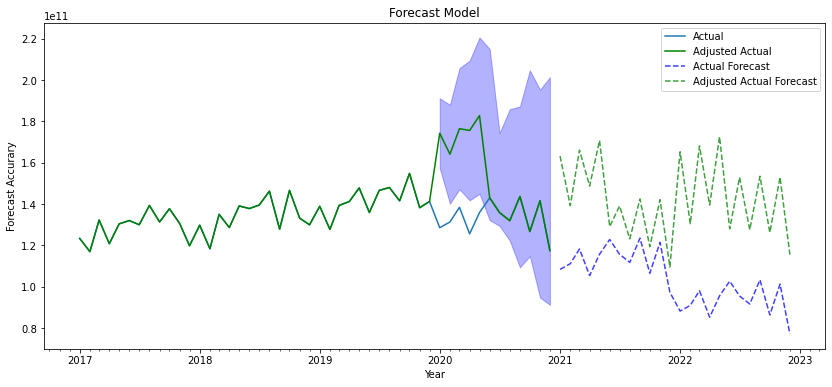

In [9]:
sw_tsfm_01.plot("ACUTE")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1150.214, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1151.888, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1151.169, Time=0.10 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1151.388, Time=0.06 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1149.190, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1150.566, Time=0.16 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=1152.567, Time=0.20 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1151.870, Time=0.11 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1153.218, Time=0.23 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1151.179, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 1.269 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1449.921, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             

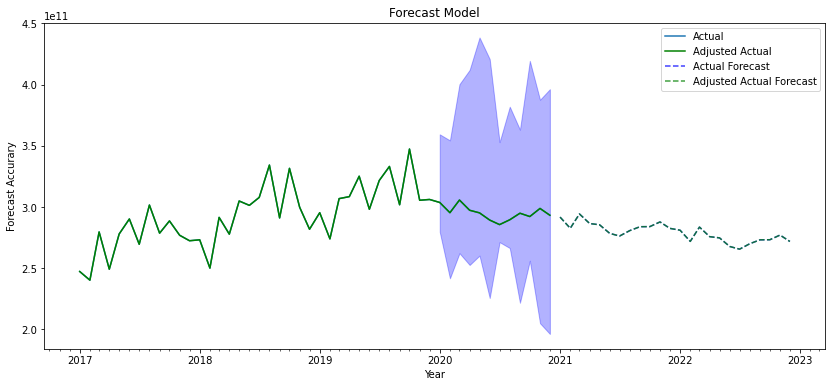

In [11]:
sw_tsfm_01.plot("HOME")

# Non-stepwise

## alpha = .05

In [33]:
nsw_tsfm_05 = TSFM(df=df, n_pred_period=24, date_variable='beg_month', target_variable='prod', value_variable='test', stop_date="2019-12-01", section_list=["HOME", "ACUTE"], stepwise=False, alpha=.05)

0,0)[12] intercept   : AIC=1708.566, Time=0.12 sec
 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=1710.270, Time=0.29 sec
 ARIMA(0,1,2)(1,0,2)[12] intercept   : AIC=1711.538, Time=0.62 sec
 ARIMA(0,1,2)(2,0,0)[12] intercept   : AIC=1710.047, Time=0.22 sec
 ARIMA(0,1,2)(2,0,1)[12] intercept   : AIC=1711.690, Time=0.70 sec
 ARIMA(0,1,3)(0,0,0)[12] intercept   : AIC=1712.307, Time=0.15 sec
 ARIMA(0,1,3)(0,0,1)[12] intercept   : AIC=1711.452, Time=0.39 sec
 ARIMA(0,1,3)(0,0,2)[12] intercept   : AIC=1712.626, Time=0.85 sec
 ARIMA(0,1,3)(1,0,0)[12] intercept   : AIC=1711.255, Time=0.14 sec
 ARIMA(0,1,3)(1,0,1)[12] intercept   : AIC=1713.225, Time=0.51 sec
 ARIMA(0,1,3)(2,0,0)[12] intercept   : AIC=1712.915, Time=1.01 sec
 ARIMA(0,1,4)(0,0,0)[12] intercept   : AIC=1725.253, Time=0.07 sec
 ARIMA(0,1,4)(0,0,1)[12] intercept   : AIC=1723.786, Time=0.12 sec
 ARIMA(0,1,4)(1,0,0)[12] intercept   : AIC=1726.305, Time=0.20 sec
 ARIMA(0,1,5)(0,0,0)[12] intercept   : AIC=1761.289, Time=0.19 sec
 ARIMA(1,1,

(1,1,2)[12]             : AIC=inf, Time=0.84 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1112.015, Time=0.18 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.95 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=1.09 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1114.231, Time=0.03 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1116.131, Time=0.12 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1116.136, Time=0.11 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=1.13 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=0.85 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=1.10 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1119.480, Time=0.13 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1121.357, Time=0.28 sec
 ARIMA(1,1,2)(0,1,2)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=1121.371, 

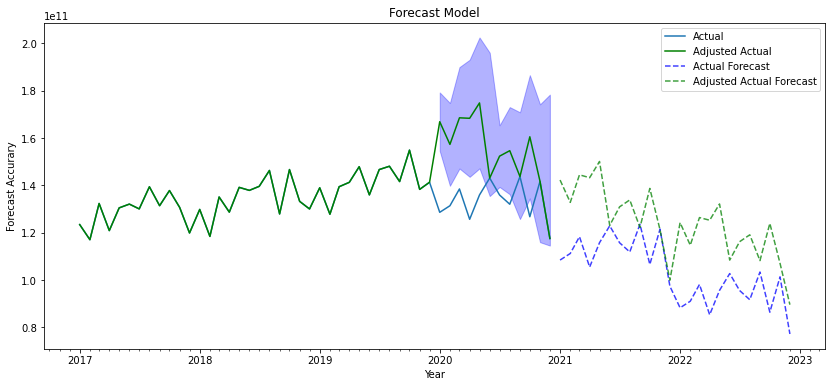

In [71]:
nsw_tsfm_05.plot("ACUTE")

 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=0.86 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1152.979, Time=0.20 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.07 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=1156.186, Time=1.74 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1151.681, Time=0.06 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1153.218, Time=0.22 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1154.364, Time=0.67 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1153.239, Time=0.19 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.81 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=1.45 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1154.302, Time=0.55 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=1.33 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1154.724, Time=0.08 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1156.166, Time=0.42 sec
 ARIMA(1,1,2)(0,1,2)[12] 

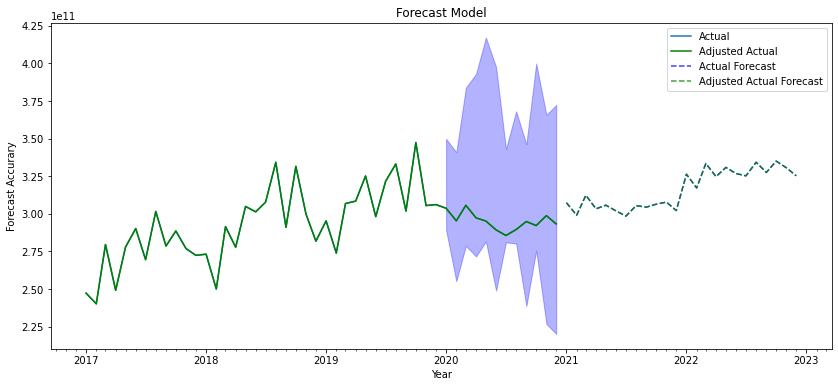

In [72]:
nsw_tsfm_05.plot("HOME")

In [73]:
nsw_tsfm_05.get_model("ACUTE", True)

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 1, 2, 12),
      suppress_warnings=True, with_intercept=False)

In [74]:
nsw_tsfm_05.get_model("ACUTE", False)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

## alpha = .01

In [34]:
nsw_tsfm_01 = TSFM(df=df, n_pred_period=24, date_variable='beg_month', target_variable='prod', value_variable='test', stop_date="2019-12-01", section_list=["HOME", "ACUTE"], stepwise=False, alpha=.01)

0,0)[12] intercept   : AIC=1708.566, Time=0.15 sec
 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=1710.270, Time=0.33 sec
 ARIMA(0,1,2)(1,0,2)[12] intercept   : AIC=1711.538, Time=0.67 sec
 ARIMA(0,1,2)(2,0,0)[12] intercept   : AIC=1710.047, Time=0.27 sec
 ARIMA(0,1,2)(2,0,1)[12] intercept   : AIC=1711.690, Time=0.70 sec
 ARIMA(0,1,3)(0,0,0)[12] intercept   : AIC=1712.307, Time=0.20 sec
 ARIMA(0,1,3)(0,0,1)[12] intercept   : AIC=1711.452, Time=0.40 sec
 ARIMA(0,1,3)(0,0,2)[12] intercept   : AIC=1712.626, Time=0.84 sec
 ARIMA(0,1,3)(1,0,0)[12] intercept   : AIC=1711.255, Time=0.18 sec
 ARIMA(0,1,3)(1,0,1)[12] intercept   : AIC=1713.225, Time=0.71 sec
 ARIMA(0,1,3)(2,0,0)[12] intercept   : AIC=1712.915, Time=0.96 sec
 ARIMA(0,1,4)(0,0,0)[12] intercept   : AIC=1725.253, Time=0.06 sec
 ARIMA(0,1,4)(0,0,1)[12] intercept   : AIC=1723.786, Time=0.11 sec
 ARIMA(0,1,4)(1,0,0)[12] intercept   : AIC=1726.305, Time=0.20 sec
 ARIMA(0,1,5)(0,0,0)[12] intercept   : AIC=1761.289, Time=0.09 sec
 ARIMA(1,1,

2] intercept   : AIC=2005.414, Time=0.26 sec
 ARIMA(0,1,3)(2,0,0)[12] intercept   : AIC=2005.016, Time=0.30 sec
 ARIMA(0,1,4)(0,0,0)[12] intercept   : AIC=2006.651, Time=0.05 sec
 ARIMA(0,1,4)(0,0,1)[12] intercept   : AIC=2005.885, Time=0.10 sec
 ARIMA(0,1,4)(1,0,0)[12] intercept   : AIC=2005.930, Time=0.11 sec
 ARIMA(0,1,5)(0,0,0)[12] intercept   : AIC=2010.980, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2007.285, Time=0.02 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2004.394, Time=0.08 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2003.451, Time=0.17 sec
 ARIMA(1,1,0)(0,0,3)[12] intercept   : AIC=2003.654, Time=0.31 sec
 ARIMA(1,1,0)(0,0,4)[12] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2003.677, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2005.400, Time=0.15 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(1,1,0)(1,0,3)[12] intercept   : AIC=inf, Time=1.99 sec
 ARIMA(1,1,0)(2,0,0)[12] interce

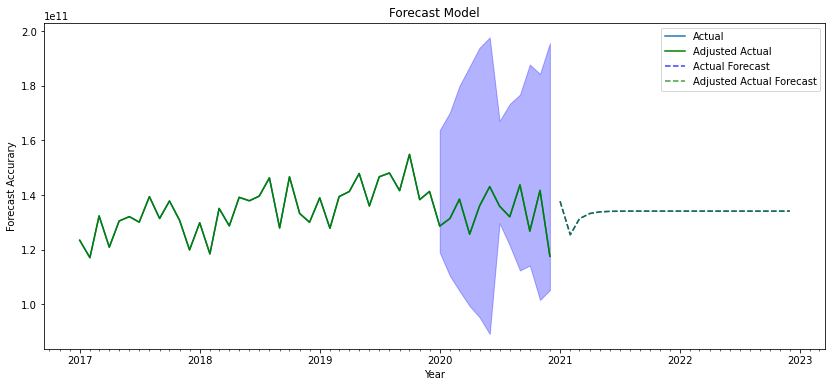

In [35]:
nsw_tsfm_01.plot("ACUTE")

In [ ]:
nsw_tsfm_01.plot("HOME")